# Drowsiness Detection

**Importing Libraries**

In [16]:
import os
import cv2
from glob import glob
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
import random, shutil
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dropout, Conv2D, Input, Flatten, Dense
from tensorflow.keras.layers import MaxPooling2D, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
%matplotlib inline
from IPython.display import SVG, Image
import tensorflow as tf
print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.13.0


**Exploring Dataset**

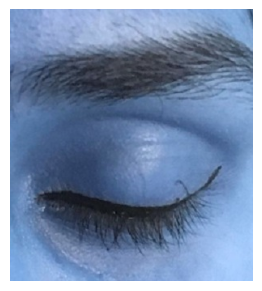

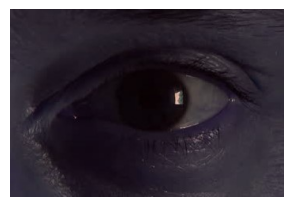

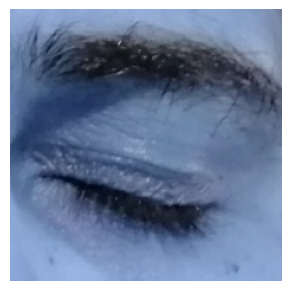

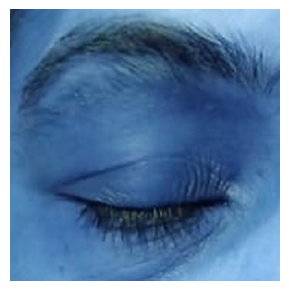

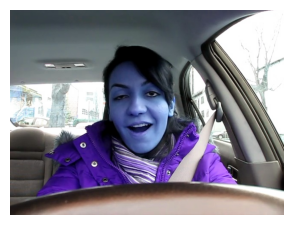

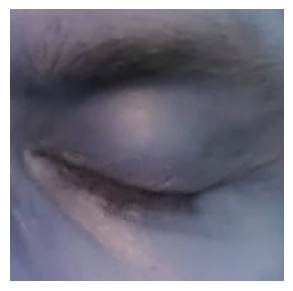

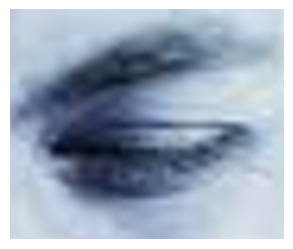

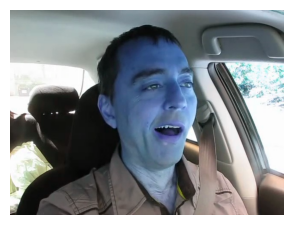

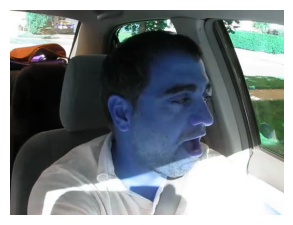

In [17]:
images = glob("train/**/**")
for i in range(9):
    image = random.choice(images)
    plt.figure(figsize=(12,12))
    plt.subplot(331+i)
    plt.imshow(cv2.imread(image));plt.axis('off')

**Preparing Data for Training**

In [18]:
img_size = 24
batch_size = 32
datagen_train = ImageDataGenerator(rescale=1./255)
train_generator = datagen_train.flow_from_directory("train/",
                                                    target_size = (img_size,img_size),
                                                    color_mode = "grayscale",
                                                    batch_size = batch_size,
                                                    class_mode = "categorical",
                                                    shuffle = True)
datagen_validation = ImageDataGenerator(rescale=1./255)
validation_generator = datagen_train.flow_from_directory("test/",
                                                    target_size = (img_size,img_size),
                                                    color_mode = "grayscale",
                                                    batch_size = batch_size,
                                                    class_mode = "categorical",
                                                    shuffle = True)

                                                    

Found 2467 images belonging to 4 classes.
Found 433 images belonging to 4 classes.


**Defining Model**

In [19]:
def Convolution(input_tensor, filters, kernel_size):
    x = Conv2D(filters = filters, kernel_size = kernel_size, padding = "same")(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size = (2,2))(x)
    x = Dropout(0.25)(x)
    return x

In [20]:
def Dense_f(input_tensor, nodes):
    x = Dense(nodes)(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.25)(x)
    return x

In [21]:
def model_ddd(input_shape):
    inputs = Input(input_shape)
    conv_1 = Convolution(inputs,32,(3,3))
    conv_2 = Convolution(inputs,64,(5,5))
    flatten = Flatten()(conv_2)
    dense_1 = Dense_f(flatten,256)
    output = Dense(4,activation = "softmax")(dense_1)
    model = Model(inputs = [inputs], outputs = [output])
    model.compile(loss = ['categorical_crossentropy'], optimizer = 'adam', metrics = ['accuracy'])
    return model

In [22]:
model = model_ddd((24,24,1))
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 24, 24, 1)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 24, 24, 64)        1664      
                                                                 
 batch_normalization_4 (Bat  (None, 24, 24, 64)        256       
 chNormalization)                                                
                                                                 
 activation_4 (Activation)   (None, 24, 24, 64)        0         
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 12, 12, 64)        0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 12, 12, 64)        0   

**Initializing the model**

In [23]:
epochs = 15
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size
checkpoint = ModelCheckpoint("model_weights.h5", monitor = 'val_accuracy', save_weights_only = True, mode = 'max', verbose = 1)
callbacks = [checkpoint]

In [24]:
history = model.fit(
    x = train_generator,
    steps_per_epoch = steps_per_epoch,
    epochs = epochs,
    validation_data = validation_generator,
    validation_steps = validation_steps,
    callbacks = callbacks)

Epoch 1/15
77/77 [==============================] - ETA: 0s - loss: 0.5560 - accuracy: 0.7639
Epoch 1: saving model to model_weights.h5
77/77 [==============================] - 33s 385ms/step - loss: 0.5560 - accuracy: 0.7639 - val_loss: 4.4052 - val_accuracy: 0.2933
Epoch 2/15
77/77 [==============================] - ETA: 0s - loss: 0.3308 - accuracy: 0.8464
Epoch 2: saving model to model_weights.h5
77/77 [==============================] - 22s 292ms/step - loss: 0.3308 - accuracy: 0.8464 - val_loss: 5.9407 - val_accuracy: 0.4014
Epoch 3/15
77/77 [==============================] - ETA: 0s - loss: 0.2698 - accuracy: 0.8817
Epoch 3: saving model to model_weights.h5
77/77 [==============================] - 22s 286ms/step - loss: 0.2698 - accuracy: 0.8817 - val_loss: 5.2241 - val_accuracy: 0.4567
Epoch 4/15
77/77 [==============================] - ETA: 0s - loss: 0.2469 - accuracy: 0.8982
Epoch 4: saving model to model_weights.h5
77/77 [==============================] - 22s 290ms/step - lo

In [25]:
model.evaluate(validation_generator)

14/14 [==============================] - 3s 229ms/step - loss: 0.3205 - accuracy: 0.8614


[0.32046476006507874, 0.861431896686554]

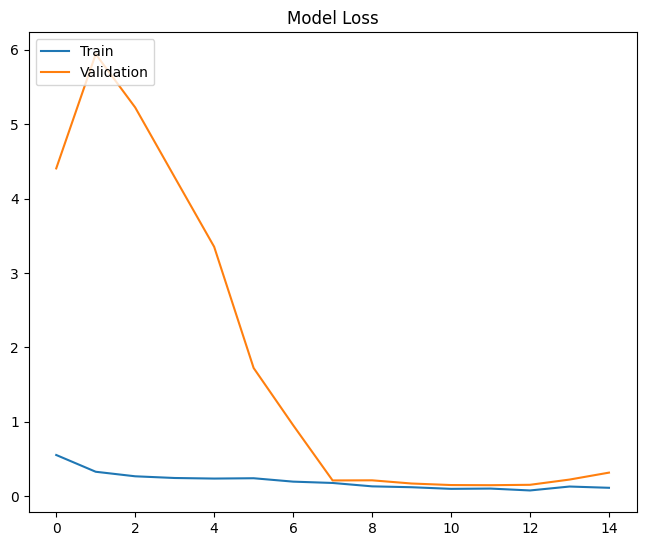

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.legend(['Train','Validation'],loc='upper left')
plt.subplots_adjust(top=1.0,bottom=0.0,right=0.95,left=0.0,hspace=0.25,wspace=0.35)

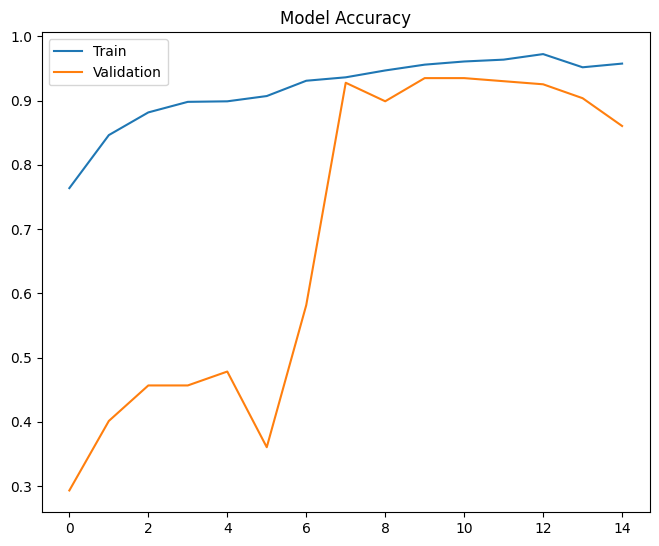

In [27]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.legend(['Train','Validation'],loc='upper left')
plt.subplots_adjust(top=1.0,bottom=0.0,right=0.95,left=0.0,hspace=0.25,wspace=0.35)

In [28]:
model_json=model.to_json()
with open("model_a.json","w") as json_file:
    json_file.write(model_json)